In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,models,transforms
from torch.autograd import Variable

import json
import numpy as np
from PIL import Image
from matplotlib import pylab as plt


In [2]:
class VanillaBackprop():
   def __init__(self, model):
     self.model = model
     self.gradients = None
     # Put model in evaluation mode
     self.model.eval()
     # Hook the first layer to get the gradient
     self.hook_layers()

   def hook_layers(self):
     def hook_function(module, grad_in, grad_out):
         print('grad_input: ',  grad_in[0].size())
         print('grad_output: ', grad_out[0].size())
         self.gradients = grad_in[0]
             
        
     first_layer = list(self.model.features._modules.items())[0][1]
     first_layer.register_backward_hook(hook_function)


   def bpimage(self,tensor,Target_class):

     out = self.model(tensor)
     self.model.zero_grad()
   
     target = torch.zeros([1,out.size()[-1]],dtype=torch.float)
     target[0][Target_class] = 1

     out.backward(gradient=target)
     gp=self.gradients.data.numpy()[0]
     print(gp.shape)

     return gp


In [3]:
def preprocessing(image):
  normalize = transforms.Normalize(
          mean =[0.485,0.456,0.406],
          std = [0.229,0.224,0.225])

  preprocess = transforms.Compose([
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          normalize])

  img_tensor = preprocess(image)
  img_tensor.unsqueeze_(0)#change 4D tensor
  img_tensor.requires_grad_(requires_grad=True)
   
  return img_tensor

In [4]:
def afprocessing(npimg):
  npimg = np.absolute(npimg)
  npimg = npimg.transpose((2,1,0))
  maxv = np.max(npimg)
  npimg = npimg/maxv
  print(npimg.shape)
  return npimg 

In [5]:
%matplotlib inline
def vg_img_show(image,vg):
    
     preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
        ])
     
     fig=plt.figure()
     ax1 = fig.add_subplot(1,2,1)
     ax1.imshow(vg)

     Img = preprocess(image)
     Img = np.array(Img)
     ax2 = fig.add_subplot(1,2,2)
     ax2.grid(color='none')
     ax2.imshow(Img)

     plt.show()

grad_input:  torch.Size([1, 3, 224, 224])
grad_output:  torch.Size([1, 64, 224, 224])
(3, 224, 224)
(224, 224, 3)


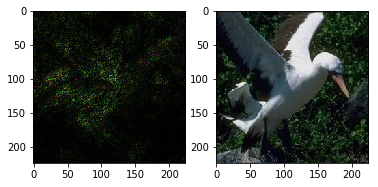

In [6]:
if __name__ == '__main__':
 image = Image.open('/export/space/okamoto-ka/imgdata2/001.jpg')
 img_tensor = preprocessing(image)
 traget_num = 146

 vgg16 =models.vgg16(pretrained=True) 
 bpi = VanillaBackprop(vgg16)

 vanilla_grads = bpi.bpimage(img_tensor,traget_num)
 n = afprocessing(vanilla_grads)
 np.save('vanilla_grads.npy',n) 
 vanilla_grads=np.load('vanilla_grads.npy')
 vg_img_show(image,vanilla_grads)